# README

- Dataset
  - Code to download and unzip dataset from Dropbox
  - Dataset stored in 'Validation' folder

- import
  - Contains all required imports
  - Pip installs if not available on the system

- Creating Embeddings
  - Mediapipe
    - Extracts keypoints from video frame folders in 'Validation'
    - Keypoints stored in 'data' folder
  - ResNet18
    - Extracts features from video frame folders in 'Validation'
    - Features stored in 'ResNet18' folder
  - ResNet50
    - Extracts features from video frame folders in 'Validation'
    - Features stored in 'ResNet50' folder
  - ResNet152_per50
    - Extracts features from video frame folders in 'Validation'
    - Features stored in 'ResNet152_per50' folder

- Lite LSTM
  - Loads dataset from 'data' folder (keypoints by mediapipe)
  - Trains LSTM model using CrossEntropy loss

- Lite LSTM Custom Loss
  - Loads dataset from 'data' folder (keypoints by mediapipe)
  - Trains LSTM model using custom loss function

- ResLSTM
  - Contains multiple LSTM models trained on key features from different pre-trained resnet models
    - ResNet18
      - Trains model on key features from ResNet18
    - ResNet50
      - Trains model on key features from ResNet50
    - ResNet152_per50
      - Trains model on key features from ResNet152_per50

- Siamese architecture
  - LSTM model trained on keypoints by mediapipe
  - Uses contrastive loss as its loss function

- Transformers
  - mediapipe embeddings
    - Trains transformer model on keypoints by mediapipe
  - ResNet18 embeddings
    - Trains transformer model on key features from ResNet18
  - ResNet50 embeddings
    - Trains transformer model on key features from ResNet50
  - ResNet152_per50 embeddings
    - Trains transformer model on key features from ResNet152_per50


# Dataset

In [ ]:
!wget -q -O "Validation.zip" "https://www.dropbox.com/scl/fi/g8atfvr1xf13pxalyc4xz/Validation.zip?rlkey=1dfox8lj9gmmkcqnoy61c0vi3&dl=0"
!wget -q -O "Validation.csv" "https://www.dropbox.com/scl/fi/3w1fxqpe8k9awni75cpi1/Validation.csv?rlkey=5xqxbqrbthp3ixpgnlfwdqtc6&dl=0"
!unzip -q -o Validation.zip

# Import

In [ ]:
!pip install opencv-python mediapipe matplotlib

/home/bcca/miniconda3/lib/python3.11/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [ ]:
!pip install torchsummary

In [ ]:
import os
import torch
from torch.utils.data import Dataset
import pandas as pd
import matplotlib.pyplot as plt
import torch.nn as nn
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
from torchsummary import summary
import math
import numpy as np
import cv2
import time
import mediapipe as mp
import torchvision.models as models
from PIL import Image
from torchvision import transforms
from torchvision import datasets
import torch as T
from torch import optim
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout
from tensorflow.keras import regularizers
import tensorflow as tf
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.optimizers import Adam
import random
from tensorflow.keras.utils import to_categorical
import sys
from torch.utils.data import TensorDataset


# Creating embeddings

## Mediapipe

In [ ]:
label_data = pd.read_csv('Validation.csv')
print(label_data)

      video_id                      label  frames  label_id       shape format
0           22  Zooming In With Full Hand      37        23  (100, 176)   JPEG
1           30               Swiping Down      37        15  (100, 176)   JPEG
2           68               Shaking Hand      37         9  (100, 176)   JPEG
3           77                 Thumb Down      37        19  (100, 176)   JPEG
4           96              Swiping Right      37        17  (100, 176)   JPEG
...        ...                        ...     ...       ...         ...    ...
7042    147945               Shaking Hand      37         9  (100, 132)   JPEG
7043    147960   Sliding Two Fingers Left      37        11  (100, 176)   JPEG
7044    148032         Doing other things      37         0  (100, 176)   JPEG
7045    148046         Doing other things      37         0  (100, 176)   JPEG
7046    148071               Swiping Left      37        16  (100, 176)   JPEG

[7047 rows x 6 columns]


In [ ]:
label_data.describe()

,video_id,frames,label_id
count,7047.000000,7047.0,7047.000000
mean,73746.899248,37.0,12.079183
std,42615.127783,0.0,8.226342
min,22.000000,37.0,0.000000
25%,36857.000000,37.0,5.000000
50%,74076.000000,37.0,12.000000
75%,110391.500000,37.0,19.000000
max,148071.000000,37.0,26.000000


In [ ]:
mp_holistic = mp.solutions.holistic
mp_drawing = mp.solutions.drawing_utils

In [ ]:
def draw_styled_landmarks(image, results):


    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )

    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [ ]:
def video_to_frames(vid_path, output_folder="Auto", total_frames=37):
    input_file_path = vid_path
    cap = cv2.VideoCapture(input_file_path)


    total_frames_in_video = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    frame_count = 0
    image_count = 0
    if output_folder=="Auto":
        vid_name=vid_path.split("/")[-1].split(".")[0]
        output_folder="./dl_project/"+vid_name

    os.makedirs(output_folder, exist_ok=True)


    for file in os.listdir(output_folder):
        os.remove(os.path.join(output_folder, file))

    sample_at_every = total_frames_in_video // total_frames


    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        frame_count += 1


        if frame_count % sample_at_every == 0:
            output_path = os.path.join(output_folder, f"frame_{image_count}.jpg")
            cv2.imwrite(output_path, frame)
            image_count += 1

        if cv2.waitKey(1) & 0xFF == ord('q'):
            break


    cap.release()
    cv2.destroyAllWindows()

    return output_folder

In [ ]:
mp_holistic = mp.solutions.holistic

In [ ]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image.flags.writeable = False
    results = model.process(image)
    image.flags.writeable = True
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    return image, results

In [ ]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS)
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS)

In [ ]:
def extract_keypoints(results):
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([lh, rh])

In [ ]:
!ls Validation


100001	112892	124989	137825	16124  28758  39725  52146  64493  76806  88190
100030	112895	124998	137832	16142  28787  3974   522    64509  76833  8820
100048	112899	125003	137855	16144  28794  39744  52252  64521  76837  88214
100090	112906	125009	137882	1615   28831  39760  52260  64527  76848  8822
100126	112931	125010	137899	16163  28854  39790  52279  64538  76867  88248
100132	112936	125026	13790	16167  28885  39804  52296  64603  76872  88284
100135	11294	12503	137900	16169  28890  39805  52298  64621  76891  88286
100145	112942	125032	137922	1618   28920  39823  52315  64625  76942  88299
100183	112962	125041	137929	16185  28968  39844  52320  64655  76954  88306
100232	113006	125075	137949	1621   28970  39872  52415  64728  76999  88309
100240	113018	1251	137957	16214  2899   39879  52440  64734  77	  88311
10026	11302	125125	137974	16239  29001  39880  52489  64749  77000  88331
100261	113025	125129	137996	16246  29104  39887  5250   64767  77039  88332
100263	113031	125228	13

I0000 00:00:1712849636.010332  899560 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1712849636.053084  948367 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.104.05), renderer: NVIDIA RTX A5000/PCIe/SSE2


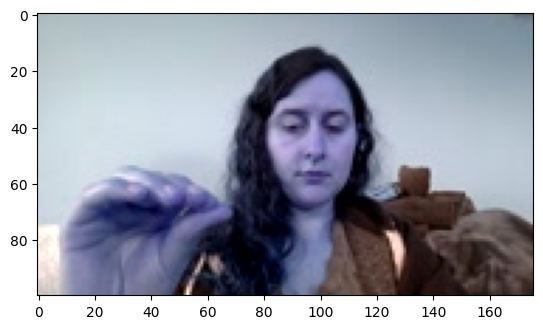

<class 'mediapipe.python.solution_base.SolutionOutputs'>


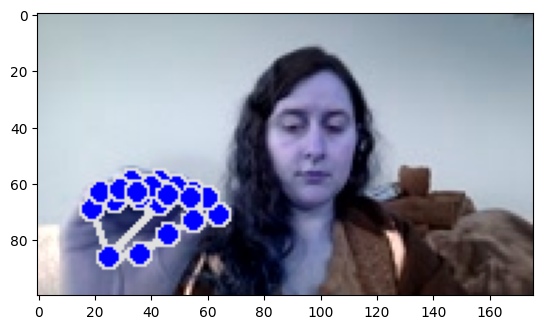

[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000

In [ ]:
with mp_holistic.Holistic(min_detection_confidence=0.0, min_tracking_confidence=0.0) as holistic:
    frame_path = 'Validation/147825/00030.jpg'
    frame = cv2.imread(frame_path)
    plt.imshow(frame)
    plt.show()
    image,results = mediapipe_detection(frame,holistic)
    draw_landmarks(image, results)
    print(results)
    plt.imshow(image)
    plt.show()
    keypoints = extract_keypoints(results)
    print(keypoints)



In [ ]:
def process_frames_in_folder(folder_path,holistic):
    keypoints_all_frames = []
    for frame_file in range(1,38):
        frame_file = "{:05d}.jpg".format(frame_file)
        frame_path = os.path.join(folder_path, str(frame_file))
        frame = cv2.imread(frame_path)
        _,results = mediapipe_detection(frame, holistic)
        keypoints = extract_keypoints(results)
        keypoints_all_frames.append(keypoints)
    return keypoints_all_frames



def process_image_folder(folder_path,holistic,output_file):

    if os.path.exists(os.path.join(folder_path,'keypoints.npy')):
        os.remove(os.path.join(folder_path,'keypoints.npy'))
    all_keypoints = process_frames_in_folder(folder_path,holistic)
    all_keypoints_array = np.array(all_keypoints)
    np.save(output_file, all_keypoints_array)

In [ ]:
i=0
os.makedirs('data',exist_ok=True)

DATA_PATH='Validation'
OUTPUT_PATH='data'
with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
    all_items = os.listdir(DATA_PATH)
    files_only = [int(item) for item in all_items if not item.startswith('.')]
    files_only.sort()
    for folder in files_only:
        folder_path = os.path.join(DATA_PATH,str(folder))
        out_path = os.path.join(OUTPUT_PATH,str(folder))
        out_path+='.npy'
        if(not os.path.exists(out_path)):
            process_image_folder(folder_path,holistic,out_path)
        i+=1
        if(i%100==0):
            print(i)

100
200
300
400
500
600
700
800
900
1000


I0000 00:00:1710512737.885675 2402298 gl_context_egl.cc:85] Successfully initialized EGL. Major : 1 Minor: 5
I0000 00:00:1710512737.903443 2402696 gl_context.cc:357] GL version: 3.2 (OpenGL ES 3.2 NVIDIA 535.104.05), renderer: NVIDIA RTX A5000/PCIe/SSE2


## ResNet18

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet18 = models.resnet18(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 125MB/s]


In [ ]:
device

device(type='cuda')

In [ ]:
resnet18.fc = nn.Identity().to(device)
summary(resnet18, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
folder_dir="ResNet18"
input_dir = os.path.join("Validation")
os.makedirs(folder_dir, exist_ok=True)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
total=len(os.listdir(input_dir))
cnt=0
for input_folder in os.listdir(input_dir):
    images=os.listdir(os.path.join(input_dir, input_folder))


    images.sort()


    dataset=[]
    for image in images:
        img = Image.open(os.path.join(input_dir, input_folder, image))
        img = transform(img)
        dataset.append(img)


    dataset = torch.stack(dataset)
    dataloader = DataLoader(dataset, batch_size=37, shuffle=False)


    outputs=resnet18(dataloader.dataset.to(device))


    output_folder=os.path.join(folder_dir, input_folder)

    os.makedirs(output_folder, exist_ok=True)


    torch.save(outputs, os.path.join(output_folder, "output.pt"))


    print(f"Percentage: {cnt/total*100:.2f}", end="\r")
    cnt+=1

## ResNet50

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
resnet50 = models.resnet50(pretrained=True).to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 133MB/s]


In [ ]:
device

device(type='cuda')

In [ ]:
resnet50.fc = nn.Identity().to(device)
summary(resnet50, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

In [ ]:
folder_dir="ResNet50"
input_dir = os.path.join("Validation")
os.makedirs(folder_dir, exist_ok=True)

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

In [ ]:
total=len(os.listdir(input_dir))
cnt=0
for input_folder in os.listdir(input_dir):
    images=os.listdir(os.path.join(input_dir, input_folder))


    images.sort()


    dataset=[]
    for image in images:
        img = Image.open(os.path.join(input_dir, input_folder, image))
        img = transform(img)
        dataset.append(img)


    dataset = torch.stack(dataset)
    dataloader = DataLoader(dataset, batch_size=37, shuffle=False)


    outputs=resnet50(dataloader.dataset.to(device))


    output_folder=os.path.join(folder_dir, input_folder)

    os.makedirs(output_folder, exist_ok=True)


    torch.save(outputs, os.path.join(output_folder, "output.pt"))


    print(f"Percentage: {cnt/total*100:.2f}", end="\r")
    cnt+=1

## ResNet152_per50

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class PartialResNet(nn.Module):
    def __init__(self):
        super(PartialResNet, self).__init__()

        self.resnet = models.resnet152(pretrained=True)
        for param in self.resnet.parameters():
            param.requires_grad = False
        self.partial_resnet = nn.Sequential(*(list(self.resnet.children())[:6]))

        self.adaptive_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(512, 512)

    def forward(self, x):
        x = self.partial_resnet(x)
        x = self.adaptive_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

model = PartialResNet().to(device)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth
100%|██████████| 230M/230M [00:02<00:00, 112MB/s]


In [ ]:
device

device(type='cuda')

In [ ]:
summary(model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
            Conv2d-2         [-1, 64, 112, 112]           9,408
       BatchNorm2d-3         [-1, 64, 112, 112]             128
       BatchNorm2d-4         [-1, 64, 112, 112]             128
              ReLU-5         [-1, 64, 112, 112]               0
              ReLU-6         [-1, 64, 112, 112]               0
         MaxPool2d-7           [-1, 64, 56, 56]               0
         MaxPool2d-8           [-1, 64, 56, 56]               0
            Conv2d-9           [-1, 64, 56, 56]           4,096
           Conv2d-10           [-1, 64, 56, 56]           4,096
      BatchNorm2d-11           [-1, 64, 56, 56]             128
      BatchNorm2d-12           [-1, 64, 56, 56]             128
             ReLU-13           [-1, 64, 56, 56]               0
             ReLU-14           [-1, 64,

In [ ]:
class GestureDataset(Dataset):
    def __init__(self, data_dir, csv_path, transform=None):
        self.data_dir = data_dir
        self.label_id_map = {}
        self.transform = transform

        data = pd.read_csv(csv_path)
        for i in range(len(data)):
            video_id = str(data['video_id'][i])
            label_id = data['label_id'][i]
            if label_id != 0:
                self.label_id_map[video_id] = label_id


        self.video_ids = sorted(self.label_id_map.keys())

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_idx = idx // 37
        rem = idx % 37
        video_id = self.video_ids[video_idx]
        video_dir = os.path.join(self.data_dir, video_id)

        if rem < 9:
            output = os.path.join(video_dir, f"0000{rem+1}.jpg")
        else:
            output = os.path.join(video_dir, f"000{rem+1}.jpg")


        img = cv2.imread(output)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        label = self.label_id_map[video_id]


        if self.transform:
            img = self.transform(img)


        label -= 1

        return img, label

In [ ]:
mean = torch.tensor([0.5, 0.5, 0.5])
std = torch.tensor([0.5, 0.5, 0.5])

normalize = transforms.Normalize(mean=mean, std=std)

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),
    normalize
])

data_dir = 'Validation'
csv_path = "Validation.csv"


dataset = GestureDataset(data_dir, csv_path, transform=transform)

In [ ]:
train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])


bs = 64
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)
print(train_dataset[0][0].shape, train_dataset[0][1])

torch.Size([3, 224, 224]) 12


/home/bcca/miniconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [ ]:
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
num_epochs = 10
for epoch in range(num_epochs):

    model.train()
    train_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
    train_loss /= len(train_loader.dataset)


    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * images.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    val_loss /= len(val_loader.dataset)
    val_accuracy = 100 * correct / total


    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%")

Epoch 1/10, Train Loss: 2.4324, Val Loss: 2.4184, Val Accuracy: 35.70%
Epoch 2/10, Train Loss: 2.4079, Val Loss: 2.3820, Val Accuracy: 41.86%
Epoch 3/10, Train Loss: 2.3830, Val Loss: 2.3627, Val Accuracy: 39.49%
Epoch 4/10, Train Loss: 2.3583, Val Loss: 2.3429, Val Accuracy: 35.39%
Epoch 5/10, Train Loss: 2.3360, Val Loss: 2.3087, Val Accuracy: 45.02%
Epoch 6/10, Train Loss: 2.3142, Val Loss: 2.2918, Val Accuracy: 44.39%
Epoch 7/10, Train Loss: 2.2932, Val Loss: 2.2767, Val Accuracy: 42.97%
Epoch 8/10, Train Loss: 2.2759, Val Loss: 2.2536, Val Accuracy: 45.02%
Epoch 9/10, Train Loss: 2.2541, Val Loss: 2.2389, Val Accuracy: 44.39%
Epoch 10/10, Train Loss: 2.2357, Val Loss: 2.2205, Val Accuracy: 42.81%


In [ ]:
folder_dir="ResNet152_per50"
input_dir = os.path.join("Validation")
os.makedirs(folder_dir, exist_ok=True)

In [ ]:
total=len(os.listdir(input_dir))
cnt=0
for input_folder in os.listdir(input_dir):
    images=os.listdir(os.path.join(input_dir, input_folder))
    images.sort()
    dataset=[]
    for image in images:
        img = Image.open(os.path.join(input_dir, input_folder, image))
        img = transform(img)
        dataset.append(img)


    dataset = torch.stack(dataset)
    dataloader = DataLoader(dataset, batch_size=37, shuffle=False)
    outputs=model(dataloader.dataset.to(device))
    output_folder=os.path.join(folder_dir, input_folder)
    os.makedirs(output_folder, exist_ok=True)
    torch.save(outputs, os.path.join(output_folder, "output.pt"))

    print(f"Percentage: {cnt/total*100:.2f}", end="\r")
    cnt+=1

/home/bcca/miniconda3/lib/python3.11/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


# Lite LSTM

In [ ]:
label_data = pd.read_csv('Validation.csv')
print(label_data)

      video_id                      label  frames  label_id       shape format
0           22  Zooming In With Full Hand      37        23  (100, 176)   JPEG
1           30               Swiping Down      37        15  (100, 176)   JPEG
2           68               Shaking Hand      37         9  (100, 176)   JPEG
3           77                 Thumb Down      37        19  (100, 176)   JPEG
4           96              Swiping Right      37        17  (100, 176)   JPEG
...        ...                        ...     ...       ...         ...    ...
7042    147945               Shaking Hand      37         9  (100, 132)   JPEG
7043    147960   Sliding Two Fingers Left      37        11  (100, 176)   JPEG
7044    148032         Doing other things      37         0  (100, 176)   JPEG
7045    148046         Doing other things      37         0  (100, 176)   JPEG
7046    148071               Swiping Left      37        16  (100, 176)   JPEG

[7047 rows x 6 columns]


In [ ]:
label_data.set_index('video_id',inplace=True)

In [ ]:
label_data.loc[3538]

label       Doing other things
frames                      37
label_id                     0
shape               (100, 176)
format                    JPEG
Name: 3538, dtype: object

In [ ]:
dataset = []

DATA_PATH = 'data'
for file in os.listdir(DATA_PATH):
    file_path = os.path.join(DATA_PATH,file)
    video_id = file.split('.')[0]
    video_id = int(video_id)
    label =  label_data.loc[video_id]['label_id']
    temp = np.load(file_path)
    dataset.append([temp,label])


In [ ]:
dataset

[[array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  12],
 [array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  20],
 [array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00, ...,
           0.00000000e+00,  0.00000000e+00,  0.00000000e+00],
         ...,
         [ 6.72039390e-01,  7.82324255e-01, -1.60778029e-07, ...,
          

In [ ]:
dataset = pd.DataFrame(dataset,columns=['keypoints','label'])

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
not_zero_df = dataset[dataset['label']!=0]
X = not_zero_df['keypoints']
y=not_zero_df['label']
y = encoder.fit_transform(np.array(y).reshape((-1,1)))

In [ ]:
not_zero_df['label'].value_counts()

label
23    262
26    261
25    260
14    259
1     257
24    257
2     256
19    250
3     250
10    249
15    248
16    247
5     246
11    246
9     245
8     244
13    244
12    242
18    241
6     241
7     239
20    238
4     233
17    231
21    196
22    192
Name: count, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y, shuffle=True, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, shuffle=True, test_size=2/3, random_state=42)

In [ ]:
print(X_train.shape,X_val.shape,X_test.shape)

(4433,) (1268,) (633,)


In [ ]:
X_train = torch.Tensor(list(X_train)).float()
y_train = torch.Tensor(list(y_train)).float()

X_test = torch.Tensor(list(X_test)).float()
y_test = torch.Tensor(list(y_test)).float()

X_val = torch.Tensor(list(X_val)).float()
y_val = torch.Tensor(list(y_val)).float()

/tmp/ipykernel_339997/2391115753.py:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X_train = torch.Tensor(list(X_train)).float()


In [ ]:
y_train.shape

torch.Size([4433, 26])

In [ ]:
y_test[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.])

In [ ]:
num_classes=26

In [ ]:
model = Sequential([
    LSTM(512, activation='relu', input_shape=(37, 42*3)),
    Dense(1024, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])
model.summary()

/home/bcca/miniconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 512)            │     1,308,672 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,968,538 (7.51 MB)

 Trainable params: 1,968,538 (7.51 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
X_train = tf.convert_to_tensor(X_train.numpy(), dtype=tf.float32)
y_train = tf.convert_to_tensor(y_train.numpy(), dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val.numpy(), dtype=tf.float32)
y_val = tf.convert_to_tensor(y_val.numpy(), dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test.numpy(), dtype=tf.float32)
y_test = tf.convert_to_tensor(y_test.numpy(), dtype=tf.float32)

In [ ]:

history = model.fit(
    X_train,
    y_train,
    validation_data=(X_val, y_val),
    epochs=200,
    callbacks=[
        ModelCheckpoint('./models/model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_acc', patience=100, verbose=1, mode='auto', restore_best_weights=True)
    ]
)


Epoch 1/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 94ms/step - acc: 0.2658 - loss: 2.3986
Epoch 1: val_acc improved from -inf to 0.15934, saving model to ./models/model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 111ms/step - acc: 0.2655 - loss: 2.3974 - val_acc: 0.1593 - val_loss: 2.8469 - learning_rate: 0.0010
Epoch 2/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - acc: 0.2170 - loss: 2.4491
Epoch 2: val_acc improved from 0.15934 to 0.18132, saving model to ./models/model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 114ms/step - acc: 0.2184 - loss: 2.4488 - val_acc: 0.1813 - val_loss: 2.9567 - learning_rate: 0.0010
Epoch 3/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 99ms/step - acc: 0.2503 - loss: 2.4469 
Epoch 3: val_acc improved from 0.18132 to 0.19231, saving model to ./models/model.keras
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 116ms/step - acc: 0.2500 - loss: 2.4460 - val_acc: 0.1923 - val_loss: 2.7173 - learning_rate: 0.0010
Epoch 4/200
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - acc: 0.2666 - loss: 3.0899
Epoch 4: val_acc did

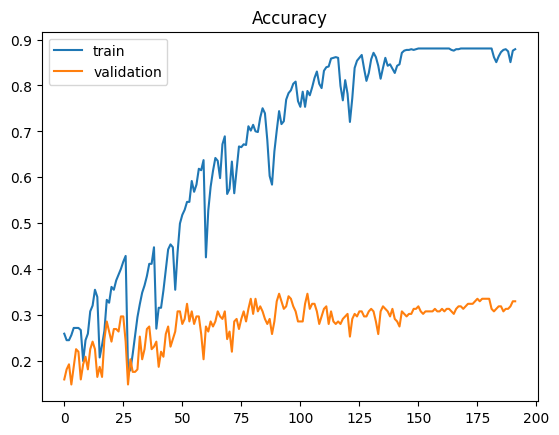

In [ ]:
# accuracy plots
plt.plot(history.history['acc'], label='train')
plt.plot(history.history['val_acc'], label='validation')
plt.legend()
plt.title('Accuracy')
plt.show()

# Lite LSTM custom loss

In [ ]:
label_data = pd.read_csv('Validation.csv')
print(label_data)

      video_id                      label  frames  label_id       shape format
0           22  Zooming In With Full Hand      37        23  (100, 176)   JPEG
1           30               Swiping Down      37        15  (100, 176)   JPEG
2           68               Shaking Hand      37         9  (100, 176)   JPEG
3           77                 Thumb Down      37        19  (100, 176)   JPEG
4           96              Swiping Right      37        17  (100, 176)   JPEG
...        ...                        ...     ...       ...         ...    ...
7042    147945               Shaking Hand      37         9  (100, 132)   JPEG
7043    147960   Sliding Two Fingers Left      37        11  (100, 176)   JPEG
7044    148032         Doing other things      37         0  (100, 176)   JPEG
7045    148046         Doing other things      37         0  (100, 176)   JPEG
7046    148071               Swiping Left      37        16  (100, 176)   JPEG

[7047 rows x 6 columns]


In [ ]:
label_data.set_index('video_id',inplace=True)

In [ ]:
label_data.loc[3538]

label       Doing other things
frames                      37
label_id                     0
shape               (100, 176)
format                    JPEG
Name: 3538, dtype: object

In [ ]:
dataset = []

DATA_PATH = 'data'
for file in os.listdir(DATA_PATH):
    file_path = os.path.join(DATA_PATH,file)
    video_id = file.split('.')[0]
    video_id = int(video_id)
    label =  label_data.loc[video_id]['label_id']
    temp = np.load(file_path)
    dataset.append([temp,label])


In [ ]:
dataset

[[array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         ...,
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.]]),
  5],
 [array([[ 0.        ,  0.        ,  0.        , ...,  0.36751708,
           0.33844846, -0.04742396],
         [ 0.        ,  0.        ,  0.        , ...,  0.34433717,
           0.33990884, -0.03616458],
         [ 0.        ,  0.        ,  0.        , ...,  0.33770522,
           0.35249043, -0.03210043],
         ...,
         [ 0.        ,  0.        ,  0.        , ...,  0.79756057,
           0.48983568,  0.01271436],
         [ 0.        ,  0.        ,  0.        , ...,  0.81527638,
           0.80489755, -0.06854827],
         [ 0.        ,  0.        ,  0.        , ...,  0.82622623,
           0.93785596, -0.08944465]]),
  22],
 [array([[0., 0., 0., ..., 0., 0., 0.],
         [0., 0., 0., ..., 0., 0., 0.],
         [0

In [ ]:
dataset = pd.DataFrame(dataset,columns=['keypoints','label'])

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
not_zero_df = dataset[dataset['label']!=0]
X = not_zero_df['keypoints']
y=not_zero_df['label']
y = encoder.fit_transform(np.array(y).reshape((-1,1)))

In [ ]:
not_zero_df['label'].value_counts()

label
23    262
26    261
25    260
14    259
1     257
24    257
2     256
19    250
3     250
10    249
15    248
16    247
11    246
5     246
9     245
8     244
13    244
12    242
6     241
18    241
7     239
20    238
4     233
17    231
21    196
22    192
Name: count, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y, shuffle=True, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, shuffle=True, test_size=2/3, random_state=42)

In [ ]:
print(X_train.shape,X_val.shape,X_test.shape)

(4433,) (1268,) (633,)


In [ ]:
X_train = torch.Tensor(list(X_train)).float()
y_train = torch.Tensor(list(y_train)).float()

X_test = torch.Tensor(list(X_test)).float()
y_test = torch.Tensor(list(y_test)).float()

X_val = torch.Tensor(list(X_val)).float()
y_val = torch.Tensor(list(y_val)).float()

In [ ]:
y_train.shape

torch.Size([4433, 26])

In [ ]:
y_test[0]

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0., 1.])

In [ ]:
num_classes=26

In [ ]:
X_train.shape

torch.Size([4433, 37, 126])

In [ ]:
y_train.shape

torch.Size([4433, 26])

In [ ]:
new_y_train=torch.zeros((y_train.shape[0],37,26))
for i in range(25):
    # new_y_train[:,i,:]=torch.zeros(y_train.shape[0],26)
    new_y_train[:,i,:] = y_train

for i in range(12):
    new_y_train[:,i+25,:]=y_train

new_y_train.shape

torch.Size([4433, 37, 26])

In [ ]:
new_y_val=torch.zeros((y_val.shape[0],37,26))
for i in range(25):
    # new_y_val[:,i,:]=torch.zeros((y_val.shape[0],26))
    new_y_val[:,i,:]=y_val

for i in range(12):
    new_y_val[:,i+25,:]=y_val

new_y_val.shape

torch.Size([1268, 37, 26])

In [ ]:
new_y_test=torch.zeros((y_test.shape[0],37,26))
for i in range(25):
    new_y_test[:,i,:]=torch.zeros((y_test.shape[0],26))

for i in range(12):
    new_y_test[:,i+25,:]=y_test

new_y_test.shape

torch.Size([633, 37, 26])

In [ ]:
l2_regularization = 0.01

model = Sequential([
    LSTM(256, activation='relu', input_shape=(37, 126), return_sequences=True, kernel_regularizer=regularizers.l2(l2_regularization)),
    Dropout(0.5),
    Dense(256, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2_regularization)),
    BatchNormalization(),
    Dropout(0.5),
    Dense(26, activation='softmax')
])


2024-04-12 20:41:32.124545: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:998] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-04-12 20:41:32.126798: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2251] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...
/home/bcca/miniconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  s

In [ ]:
_lamda = 1

class CustomCallback(Callback):
    def on_epoch_begin(self, epoch, logs=None):
        self.epoch = epoch

def custom_loss(y_true, y_pred):
    global _lamda
    global callback

    print(f"y_true: {y_true.shape}, y_pred: {y_pred.shape}")

    # first 25 frames
    y_true_1 = y_true[:, :25, :]
    y_pred_1 = y_pred[:, :25, :]

    # last 12 frames
    y_true_2 = y_true[:, 25:, :]
    y_pred_2 = y_pred[:, 25:, :]

    # cross entropy loss
    loss_1 = tf.keras.losses.categorical_crossentropy(y_true_1, y_pred_1)
    loss_2 = tf.keras.losses.categorical_crossentropy(y_true_2, y_pred_2)

    def mult_param(_lamda, _epochs):
        return 0

    total_loss = 0
    for i in range(25):
        total_loss += loss_1[:, i] * math.exp(i/(37))
        # total_loss += loss_1[:, i] * math.pow(i, 3)
    for i in range(12):
        total_loss += loss_2[:, i] * math.exp((i+25)/(37))
        # total_loss += loss_2[:, i] * math.pow((i+25), 3)

    total_loss = tf.reduce_mean(total_loss)

    # total_loss = tf.reduce_mean(loss_1) + tf.reduce_mean(loss_2)

    print(f"Iteration: {callback.epoch}, Lambda: {mult_param(_lamda, callback.epoch)}, Loss: {total_loss}")
    return total_loss


beta_1 = 0.99
beta_2 = 0.9999

optimizer = Adam()
model.compile(optimizer=optimizer, loss=custom_loss, metrics=['acc'])


In [ ]:
X_train = tf.convert_to_tensor(X_train.numpy(), dtype=tf.float32)
new_y_train = tf.convert_to_tensor(new_y_train.numpy(), dtype=tf.float32)
X_val = tf.convert_to_tensor(X_val.numpy(), dtype=tf.float32)
new_y_val = tf.convert_to_tensor(new_y_val.numpy(), dtype=tf.float32)
X_test = tf.convert_to_tensor(X_test.numpy(), dtype=tf.float32)
new_y_test = tf.convert_to_tensor(new_y_test.numpy(), dtype=tf.float32)

In [ ]:

batch_size = 1024

callback = CustomCallback()

checkpoint_filepath = 'best_model.keras'
checkpoint_callback = ModelCheckpoint(
    checkpoint_filepath,
    monitor='val_loss',
    save_best_only=True,
    mode='min',
    verbose=1
)

history = model.fit(
    X_train,
    new_y_train,
    validation_data=(X_val, new_y_val),
    batch_size=batch_size,
    epochs=120,
    callbacks=[
        checkpoint_callback,
        callback
    ]
)




Epoch 1/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.3721 - loss: 78957.3984
Epoch 1: val_loss improved from inf to 102530.59375, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 1s/step - acc: 0.3722 - loss: 79166.1250 - val_acc: 0.3548 - val_loss: 102530.5938
Epoch 2/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.3736 - loss: 80838.2578
Epoch 2: val_loss did not improve from 102530.59375
5/5 ━━━━━━━━━━━━━━━━━━━━ 10s 2s/step - acc: 0.3734 - loss: 80652.7656 - val_acc: 0.3546 - val_loss: 104135.9844
Epoch 3/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - acc: 0.3664 - loss: 82195.4219
Epoch 3: val_loss did not improve from 102530.59375
5/5 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step - acc: 0.3671 - loss: 81932.3438 - val_acc: 0.3537 - val_loss: 102828.0703
Epoch 4/120
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - acc: 0.3730 - loss: 80952.3281
Epoch 4: val_loss improved from 102530.59375 to 102431.93750, saving model to best_model.keras
5/5 ━━━━━━━━━━━━━━━━━━━━ 17s 4s/step - acc: 0.3728 - lo

In [ ]:
def accuracy(X_test,y_test):
    y_pred = model.predict(X_test)
    y_pred = np.argmax(y_pred, axis=2)
    y_true = np.argmax(y_test, axis=2)
    y_pred=y_pred[:,-1].reshape(-1,1)
    y_true=y_true[:,-1].reshape(-1,1)
    correct = 0
    total = 0
    for i in range(y_pred.shape[0]):
        for j in range(y_pred.shape[1]):
            if y_true[i,j]==y_pred[i,j]:
                correct+=1
            total+=1
    return correct/total

print(f"Test Accuracy: {accuracy(X_test,new_y_test)}")
print(f"Validation Accuracy: {accuracy(X_val,new_y_val)}")
print(f"Train Accuracy: {accuracy(X_train,new_y_train)}")

# load best model
model.load_weights(checkpoint_filepath)
print(f"Best Model")

print(f"Test Accuracy: {accuracy(X_test,new_y_test)}")
print(f"Validation Accuracy: {accuracy(X_val,new_y_val)}")
print(f"Train Accuracy: {accuracy(X_train,new_y_train)}")

# save
# model.save('prakhar3.keras')

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 43ms/step
Test Accuracy: 0.6208530805687204
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 51ms/step
Validation Accuracy: 0.6159305993690851
139/139 ━━━━━━━━━━━━━━━━━━━━ 10s 75ms/step
Train Accuracy: 0.7811865553801037
Best Model
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step
Test Accuracy: 0.6003159557661928
40/40 ━━━━━━━━━━━━━━━━━━━━ 2s 54ms/step
Validation Accuracy: 0.6072555205047319
139/139 ━━━━━━━━━━━━━━━━━━━━ 11s 80ms/step
Train Accuracy: 0.7083239341303857


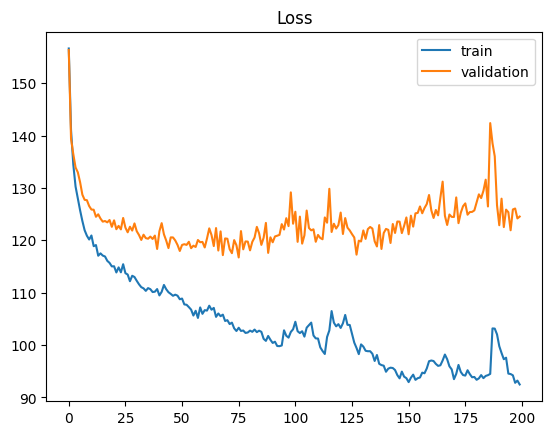

In [ ]:
# Loss Plot
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='validation')
plt.legend()
plt.title('Loss')
plt.show()

# ResLSTM

## ResNet18 Embeddings

In [ ]:
class GestureDataset(Dataset):
    def __init__(self, data_dir, csv_path):
        self.data_dir = data_dir
        self.label_id_map = {}
        data = pd.read_csv(csv_path, encoding='utf-8')
        for i in range(len(data)):
            video_id = str(data['video_id'][i])
            label_id = data['label_id'][i]
            if label_id != 0:
                self.label_id_map[video_id] = label_id


        self.video_ids = sorted(self.label_id_map.keys())

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        video_dir = os.path.join(self.data_dir, video_id)
        output = os.path.join(video_dir, 'output.pt')
        resnet_result = torch.load(output)
        label = self.label_id_map[video_id]
        return resnet_result, label-1

In [ ]:
data_dir = 'ResNet18'

csv_path = "Validation.csv"
dataset = GestureDataset(data_dir, csv_path)


train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:
bs = len(dataset)
num_classes=26
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

print(train_dataset[0][0].shape, train_dataset[0][1])

torch.Size([37, 512]) 14


In [ ]:
for batch in train_loader:
    X_train, y_train = batch
    X_train, y_train = X_train.cpu().detach(), y_train.cpu().detach()
    y_train = to_categorical(y_train, num_classes)

for batch in val_loader:
    X_val, y_val = batch
    X_val, y_val = X_val.cpu().detach(), y_val.cpu().detach()
    y_val = to_categorical(y_val, num_classes)

for batch in test_loader:
    X_test, y_test = batch
    X_test, y_test = X_test.cpu().detach(), y_test.cpu().detach()
    y_test = to_categorical(y_test, num_classes)

X_train.shape,y_train.shape

(torch.Size([4433, 37, 512]), (4433, 26))

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:

model = Sequential([
    LSTM(1024, activation='relu', input_shape=(37, 512)),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
model.summary()


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=100,
    callbacks=[
        ModelCheckpoint('./models/model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_acc', patience=100, verbose=1, mode='auto', restore_best_weights=True)
    ]
)


test_loss, test_acc = model.evaluate(X_test, y_test)
model.save('resnetLSTM18.keras')


print(f'Test accuracy: {test_acc:.4f}')

/home/bcca/miniconda3/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 1024)           │     6,295,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_17 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_18 (Dense)                │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,938,970 (30.28 MB)

 Trainable params: 7,938,970 (30.28 MB)

 Non-trainable params: 0 (0.00 B)

20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 137ms/step - acc: 0.4473 - loss: 1.2434
Test accuracy: 0.4473


## ResNet50 Embeddings

In [ ]:
class GestureDataset(Dataset):
    def __init__(self, data_dir, csv_path):
        self.data_dir = data_dir
        self.label_id_map = {}
        data = pd.read_csv(csv_path, encoding='utf-8')
        for i in range(len(data)):
            video_id = str(data['video_id'][i])
            label_id = data['label_id'][i]
            if label_id != 0:
                self.label_id_map[video_id] = label_id


        self.video_ids = sorted(self.label_id_map.keys())

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        video_dir = os.path.join(self.data_dir, video_id)
        output = os.path.join(video_dir, 'output.pt')
        resnet_result = torch.load(output)
        label = self.label_id_map[video_id]
        return resnet_result, label-1

In [ ]:

data_dir = 'ResNet50'

csv_path = "Validation.csv"
dataset = GestureDataset(data_dir, csv_path)


train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

In [ ]:

bs = len(dataset)
num_classes=26
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

print(train_dataset[0][0].shape, train_dataset[0][1])

torch.Size([37, 2048]) 25


In [ ]:
for batch in train_loader:
    X_train, y_train = batch
    X_train, y_train = X_train.cpu().detach(), y_train.cpu().detach()
    y_train = to_categorical(y_train, num_classes)

for batch in val_loader:
    X_val, y_val = batch
    X_val, y_val = X_val.cpu().detach(), y_val.cpu().detach()
    y_val = to_categorical(y_val, num_classes)

for batch in test_loader:
    X_test, y_test = batch
    X_test, y_test = X_test.cpu().detach(), y_test.cpu().detach()
    y_test = to_categorical(y_test, num_classes)

X_train.shape,y_train.shape

(torch.Size([4433, 37, 2048]), (4433, 26))

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
model = Sequential([
    LSTM(1024, activation='relu', input_shape=(37, 2048)),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
model.summary()


history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=5,
    callbacks=[
        ModelCheckpoint('./models/model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_acc', patience=100, verbose=1, mode='auto', restore_best_weights=True)
    ]
)


test_loss, test_acc = model.evaluate(X_test, y_test)
model.save('resnetLSTM50.keras')

print(f'Test accuracy: {test_acc:.4f}')

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_3 (LSTM)                   │ (None, 1024)           │    12,587,008 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,230,426 (54.28 MB)

 Trainable params: 14,230,426 (54.28 MB)

 Non-trainable params: 0 (0.00 B)

20/20 ━━━━━━━━━━━━━━━━━━━━ 5s 208ms/step - acc: 0.7937 - loss: 0.5882
Test accuracy: 0.7937


## ResNet152 Embeddings

In [ ]:
class GestureDataset(Dataset):
    def __init__(self, data_dir, csv_path):
        self.data_dir = data_dir
        self.label_id_map = {}
        data = pd.read_csv(csv_path, encoding='utf-8')
        for i in range(len(data)):
            video_id = str(data['video_id'][i])
            label_id = data['label_id'][i]
            if label_id != 0:
                self.label_id_map[video_id] = label_id


        self.video_ids = sorted(self.label_id_map.keys())

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        video_dir = os.path.join(self.data_dir, video_id)
        output = os.path.join(video_dir, 'output.pt')
        resnet_result = torch.load(output)
        label = self.label_id_map[video_id]
        return resnet_result, label-1

In [ ]:

data_dir = 'ResNet152_per50'
csv_path = "Validation.csv"
dataset = GestureDataset(data_dir, csv_path)


train_size = int(0.7 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])



In [ ]:

bs = len(dataset)
num_classes=26
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)

print(train_dataset[0][0].shape, train_dataset[0][1])

torch.Size([37, 512]) 13


In [ ]:
for batch in train_loader:
    X_train, y_train = batch
    X_train, y_train = X_train.cpu().detach(), y_train.cpu().detach()
    y_train = to_categorical(y_train, num_classes)

for batch in val_loader:
    X_val, y_val = batch
    X_val, y_val = X_val.cpu().detach(), y_val.cpu().detach()
    y_val = to_categorical(y_val, num_classes)

for batch in test_loader:
    X_test, y_test = batch
    X_test, y_test = X_test.cpu().detach(), y_test.cpu().detach()
    y_test = to_categorical(y_test, num_classes)

X_train.shape,y_train.shape

(torch.Size([4433, 37, 512]), (4433, 26))

In [ ]:
X_train = np.array(X_train)
y_train = np.array(y_train)
X_val = np.array(X_val)
y_val = np.array(y_val)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
model = Sequential([
    LSTM(1024, activation='relu', input_shape=(37, 512)),
    Dense(1024, activation='relu'),
    Dense(512, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])


opt = Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['acc'])
model.summary()

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=25,
    callbacks=[
        ModelCheckpoint('./models/model.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_acc', patience=100, verbose=1, mode='auto', restore_best_weights=True)
    ]
)


test_loss, test_acc = model.evaluate(X_test, y_test)
print(f'Test accuracy: {test_acc:.4f}')


model.save('resnetLSTM_152.keras')

Model: "sequential_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_10 (LSTM)                  │ (None, 1024)           │     6,295,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_39 (Dense)                │ (None, 1024)           │     1,049,600 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_40 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_41 (Dense)                │ (None, 128)            │        65,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_42 (Dense)                │ (None, 26)             │         3,354 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,938,970 (30.28 MB)

 Trainable params: 7,938,970 (30.28 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 390ms/step - acc: 0.0330 - loss: 63.5554
Epoch 1: val_acc improved from -inf to 0.03397, saving model to ./models/model.keras
139/139 ━━━━━━━━━━━━━━━━━━━━ 63s 434ms/step - acc: 0.0330 - loss: 63.4839 - val_acc: 0.0340 - val_loss: 5.2657 - learning_rate: 1.0000e-04
Epoch 2/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 395ms/step - acc: 0.0393 - loss: 5.1519
Epoch 2: val_acc did not improve from 0.03397
139/139 ━━━━━━━━━━━━━━━━━━━━ 60s 435ms/step - acc: 0.0393 - loss: 5.1429 - val_acc: 0.0340 - val_loss: 3.2739 - learning_rate: 1.0000e-04
Epoch 3/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 386ms/step - acc: 0.0416 - loss: 3.3081
Epoch 3: val_acc did not improve from 0.03397
139/139 ━━━━━━━━━━━━━━━━━━━━ 59s 426ms/step - acc: 0.0416 - loss: 3.3080 - val_acc: 0.0340 - val_loss: 3.2581 - learning_rate: 1.0000e-04
Epoch 4/25
139/139 ━━━━━━━━━━━━━━━━━━━━ 0s 384ms/step - acc: 0.0397 - loss: 3.2596
Epoch 4: val_acc did not improve from 0.03397
139/139 ━━━━━━━━━━━━━━━━━━━━ 

# Siamese Architecture

In [ ]:
label_data = pd.read_csv('Validation.csv')
print(label_data)

      video_id                      label  frames  label_id       shape format
0           22  Zooming In With Full Hand      37        23  (100, 176)   JPEG
1           30               Swiping Down      37        15  (100, 176)   JPEG
2           68               Shaking Hand      37         9  (100, 176)   JPEG
3           77                 Thumb Down      37        19  (100, 176)   JPEG
4           96              Swiping Right      37        17  (100, 176)   JPEG
...        ...                        ...     ...       ...         ...    ...
7042    147945               Shaking Hand      37         9  (100, 132)   JPEG
7043    147960   Sliding Two Fingers Left      37        11  (100, 176)   JPEG
7044    148032         Doing other things      37         0  (100, 176)   JPEG
7045    148046         Doing other things      37         0  (100, 176)   JPEG
7046    148071               Swiping Left      37        16  (100, 176)   JPEG

[7047 rows x 6 columns]


In [ ]:
label_data.set_index('video_id',inplace=True)

In [ ]:
label_data.loc[3538]

label       Doing other things
frames                      37
label_id                     0
shape               (100, 176)
format                    JPEG
Name: 3538, dtype: object

In [ ]:
dataset = []

DATA_PATH = 'data'
for file in os.listdir(DATA_PATH):
    file_path = os.path.join(DATA_PATH,file)
    video_id = file.split('.')[0]
    video_id = int(video_id)
    label =  label_data.loc[video_id]['label_id']
    temp = np.load(file_path)
    dataset.append([temp,label])


In [ ]:
dataset = pd.DataFrame(dataset,columns=['keypoints','label'])

In [ ]:
dataset.head()

,keypoints,label
0,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",12
1,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",20
2,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",0
3,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",1
4,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...",2


In [ ]:
dataset.loc[0]['keypoints'].shape

(37, 126)

In [ ]:
dataset.describe()

,label
count,7047.000000
mean,12.079183
std,8.226342
min,0.000000
25%,5.000000
50%,12.000000
75%,19.000000
max,26.000000


In [ ]:
dataset['label'].value_counts()

label
0     713
23    262
26    261
25    260
14    259
1     257
24    257
2     256
3     250
19    250
10    249
15    248
16    247
11    246
5     246
9     245
8     244
13    244
12    242
18    241
6     241
7     239
20    238
4     233
17    231
21    196
22    192
Name: count, dtype: int64

In [ ]:
encoder = OneHotEncoder(sparse_output=False)
not_zero_df = dataset[dataset['label']!=0]
X = dataset['keypoints'].to_numpy()
y=dataset['label'].to_numpy()
y_encoded = encoder.fit_transform(dataset['label'].values.reshape(-1, 1))

In [ ]:
X[0].shape

(37, 126)

In [ ]:
y_encoded.shape

(7047, 27)

In [ ]:
not_zero_df['label'].value_counts()

label
23    262
26    261
25    260
14    259
1     257
24    257
2     256
19    250
3     250
10    249
15    248
16    247
5     246
11    246
9     245
8     244
13    244
12    242
18    241
6     241
7     239
20    238
4     233
17    231
21    196
22    192
Name: count, dtype: int64

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y,stratify = y, shuffle=True, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, stratify = y_test, shuffle=True, test_size=2/3, random_state=42)

In [ ]:
print(X_train.shape,X_val.shape,X_test.shape)
print(y_train.shape,y_val.shape,y_test.shape)

(4932,) (1410,) (705,)
(4932,) (1410,) (705,)


In [ ]:
print(type(y_train),type(y_test),type(y_val))

<class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


In [ ]:
X_train = torch.Tensor(list(X_train)).float()
y_train = torch.Tensor(list(y_train)).float()

X_test = torch.Tensor(list(X_test)).float()
y_test = torch.Tensor(list(y_test)).float()

X_val = torch.Tensor(list(X_val)).float()
y_val = torch.Tensor(list(y_val)).float()

<ipython-input-147-0d24d12aa9d0>:1: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:275.)
  X_train = torch.Tensor(list(X_train)).float()


In [ ]:
device = T.device("cuda")

In [ ]:
first_image_array = []
first_label_array = []

for image, label in zip(X_train,y_train):
  first_image_array.append(image)
  first_label_array.append(label)


In [ ]:
len(first_label_array)

4932

In [ ]:
r = len(first_image_array)//2
tempimagearray = first_image_array
templabelarray = first_label_array
firstsetimagearray = []
firstsetlabelarray = []
secondsetimagearray = []
secondsetlabelarray = []
flagarray = []
flag = 0

for i in range(r):
  num = random.randint(r, len(first_image_array)-1)
  if (first_label_array[i] == templabelarray[num]).all():
    flag = 0
  else: flag = 1
  flag = T.tensor(flag, dtype=T.float32).to(device)
  firstsetimagearray.append(first_image_array[i])
  firstsetlabelarray.append(first_label_array[i])
  secondsetimagearray.append(tempimagearray[num])
  secondsetlabelarray.append(templabelarray[num])
  flagarray.append(flag)

In [ ]:
a = np.array(firstsetlabelarray,dtype="float32")
b = np.array(firstsetimagearray,dtype="float32")
c = np.array(secondsetlabelarray,dtype="float32")
d = np.array(secondsetimagearray,dtype="float32")


In [ ]:
print(a.shape,b.shape,c.shape,d.shape)

(2466,) (2466, 37, 126) (2466,) (2466, 37, 126)


In [ ]:
class Siamese_Training_Dataset(T.utils.data.Dataset):

  def __init__(self, firstsetfeatures,firstsetlabels, secondsetfeatures, secondsetlabels, flagarray):
    self.dataset_size = len(firstsetfeatures)
    self.firstsetfeatures = firstsetfeatures
    self.firstsetlabels = firstsetlabels
    self.secondsetfeatures = secondsetfeatures
    self.secondsetlabels = secondsetlabels
    self.flagarray = flagarray

  def __len__(self):
    return self.dataset_size

  def __getitem__(self, index):
    image1 = self.firstsetfeatures[index]
    image1 = image1.reshape(1, 37, 126)
    label1 = self.firstsetlabels[index]
    image2 = self.secondsetfeatures[index]
    image2 = image2.reshape(1, 37, 126)
    label2 = self.secondsetlabels[index]
    flag = flagarray[index]
    return(image1, label1, image2, label2, flag)

In [ ]:
siamese_ds = Siamese_Training_Dataset(b,a, d,c, flagarray)
siamese_dataloader = DataLoader(siamese_ds, batch_size=50, shuffle=True)



In [ ]:
class ContrastiveLoss(nn.Module):
  def __init__(self, margin):
    super(ContrastiveLoss, self).__init__()
    self.margin = margin

  def forward(self, out1, out2, flag):



    euclidean_distance = T.nn.functional.pairwise_distance(out1, out2)

    loss = T.mean((1-flag) * T.pow(euclidean_distance, 2) +
      (flag) * T.pow(T.clamp(self.margin - euclidean_distance, min=0.0), 2))

    return loss

In [ ]:
class LSTM_Siamese_network(nn.Module):
  def __init__(self, input_len, hidden_size, num_classes, n_layers):
    super(LSTM_Siamese_network, self).__init__()
    self.hidden_size = hidden_size
    self.n_layers = n_layers
    self.lstm = nn.LSTM(input_len, hidden_size, n_layers, batch_first=True)
    self.output_layer = nn.Linear(hidden_size, num_classes)

  def feed(self, X):
    hidden_states = T.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)
    cell_states = T.zeros(self.n_layers, X.size(0), self.hidden_size).to(device)
    output, hide = self.lstm(X, (hidden_states, cell_states))
    output = self.output_layer(output[:,-1,:])
    return output

  def forward(self, x1, x2):
    out1 = self.feed(x1)
    out2 = self.feed(x2)
    return out1, out2


In [ ]:
lstm_siamese_train = LSTM_Siamese_network(126, 256, 27, 3).to(device)

In [ ]:
np.random.seed(1)
T.manual_seed(1)
print("\nLoading 30000 item training dataset")
print("\nCreating LSTM Siamese network")
print(lstm_siamese_train)

max_epoch = 50
learning_rate = 0.001
arraylosses2 = []

loss2 = ContrastiveLoss(2.0)
opt2= T.optim.Adam(lstm_siamese_train.parameters(), lr=learning_rate)


print("loss = Contrastive Loss")
print("optimizer = Adam")
print("maximum epochs = %3d " % max_epoch)
print("learning rate = %0.3f " % learning_rate)
print("\nStarting training")
lstm_siamese_train.train()


for epoch in range(0, max_epoch):
    con_loss = 0
    for batch, (image1, label1, image2, label2, flag) in enumerate(siamese_dataloader):

        image1 = image1.reshape(-1, 37, 126).to(device)
        image2 = image2.reshape(-1, 37, 126).to(device)
        out1, out2 = lstm_siamese_train(image1, image2)

        lossfunction2 = loss2(out1, out2, flag)

        con_loss += lossfunction2.item()

        opt2.zero_grad()

        lossfunction2.backward()

        opt2.step()


    arraylosses2.append(con_loss / len(siamese_dataloader))
    if epoch%10==0:
        print("Epoch...{}".format(epoch + 1), "Contrastive loss...{}".format(con_loss / len(siamese_dataloader)))
print("Done ")


Loading 30000 item training dataset

Creating LSTM Siamese network
LSTM_Siamese_network(
  (lstm): LSTM(126, 256, num_layers=3, batch_first=True)
  (output_layer): Linear(in_features=256, out_features=27, bias=True)
)
loss = Contrastive Loss
optimizer = Adam
maximum epochs =  50 
learning rate = 0.001 

Starting training
Epoch...1 Contrastive loss...1.2144305050373077
Epoch...11 Contrastive loss...0.3526977005600929
Epoch...21 Contrastive loss...0.2776558158919215
Epoch...31 Contrastive loss...0.2211393279209733
Epoch...41 Contrastive loss...0.1872209456562996
Done 


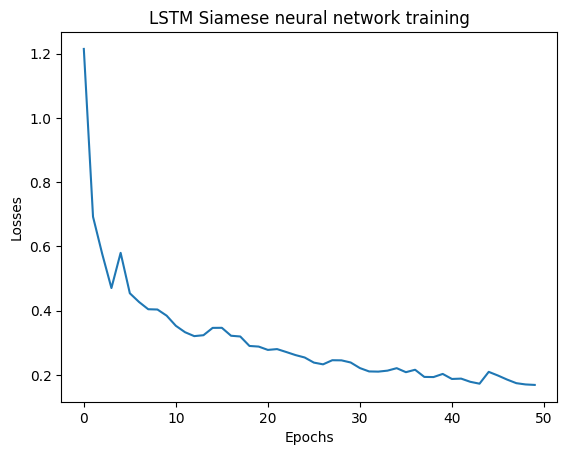

In [ ]:
plt.plot(range(max_epoch), arraylosses2)
plt.xlabel("Epochs")
plt.ylabel("Losses")
plt.title("LSTM Siamese neural network training")
plt.show()

In [ ]:
lstm_siamese_train.eval()

LSTM_Siamese_network(
  (lstm): LSTM(126, 256, num_layers=3, batch_first=True)
  (output_layer): Linear(in_features=256, out_features=27, bias=True)
)

In [ ]:

grouped_features = {}


for features, label in zip(X_test, y_test):
    label=int(label)
    if label not in grouped_features:
        print(label)
        grouped_features[label] = []
    grouped_features[label].append(features)


arrayoftestnumbers = [grouped_features[label] for label in sorted(grouped_features)]




25
14
1
26
8
5
19
12
10
15
11
20
17
23
4
21
22
24
18
16
3
0
9
6
2
13
7


In [ ]:
def EvaluateSiamese(image):
    sumdist = []
    resultsarray = []
    euclid_distance = None
    for i in range(len(arrayoftestnumbers)):
        num = 0
        for ii in range(27):
            num = random.randint(0,len(arrayoftestnumbers[i])-1)
            with T.no_grad():
                out1, out2 = lstm_siamese_train(image.view(-1, 37, 126), arrayoftestnumbers[i][num].view(-1, 37, 126).to(device))
                dist = torch.nn.functional.pairwise_distance(out1, out2)
            sumdist.append(dist)
        result = sum(sumdist) / 10
        sumdist = []
        resultsarray.append(result)

    euclid_distance = min(resultsarray)
    correctanswer = resultsarray.index(euclid_distance)
    return resultsarray,correctanswer, euclid_distance

In [ ]:
print(X_test.shape)

torch.Size([705, 37, 126])


In [ ]:
test_dataset = TensorDataset(X_test, y_test)


test_dataloader = DataLoader(test_dataset, batch_size=1, shuffle=False)

train_dataset = TensorDataset(X_train, y_train)


train_dataloader = DataLoader(train_dataset, batch_size=1, shuffle=False)



In [ ]:
lstm_siamese_train = lstm_siamese_train.to(device)
accuracy=0
from tqdm import tqdm
with T.no_grad():
    lstm_siamese_train.eval()
    for data,label in tqdm(test_dataloader):
        data=data.to(device)
        output, pred,_ = EvaluateSiamese(data)
        if(pred==label):
            accuracy+=1





100%|██████████| 705/705 [01:11<00:00,  9.89it/s]


In [ ]:
print(accuracy/len(test_dataloader))

0.13049645390070921


# Transformers

## Mediapipe Embeddings

In [ ]:
class GestureDataset(Dataset):
    def __init__(self, data_dir, csv_path):
        self.data_dir = data_dir
        self.label_id_map = {}
        data = pd.read_csv(csv_path)
        for i in range(len(data)):
            video_id = str(data['video_id'][i])
            label_id = data['label_id'][i]
            if label_id != 0:
                self.label_id_map[video_id] = label_id
        self.video_ids = sorted(self.label_id_map.keys())

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        video_dir = os.path.join(self.data_dir, video_id)
        file = f"{video_dir}.npy"
        resnet_result = np.load(file).astype(np.float32)
        label = self.label_id_map[video_id]
        return resnet_result, label - 1

data_dir = 'data'
csv_path = "Validation.csv"
dataset = GestureDataset(data_dir, csv_path)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

bs = 16
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)


print(f"Size of train_dataset: {train_size}")
print(f"Size of val_dataset: {val_size}")
print(f"Size of test_dataset: {test_size}")


Size of train_dataset: 5067
Size of val_dataset: 633
Size of test_dataset: 634


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super(MultiHeadAttention, self).__init__()
        assert d_model % nhead == 0
        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead
        self.fc_query = nn.Linear(d_model, d_model)
        self.fc_key = nn.Linear(d_model, d_model)
        self.fc_value = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value):
        batch_size = query.size(0)

        query = self.fc_query(query).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)
        key = self.fc_key(key).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)
        value = self.fc_value(value).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)

        scores = torch.matmul(query, key.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = torch.softmax(scores, dim=-1)
        attended_values = torch.matmul(attn_weights, value)

        concat_attended_values = attended_values.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        out = self.fc_out(concat_attended_values)
        return out

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, nhead)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        src2 = self.self_attn(src, src, src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        temp3 = self.linear1(src)
        temp2 = torch.relu(temp3)
        temp1 = self.dropout(temp2)
        src2 = self.linear2(temp1)
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class TemporalEncoder(nn.Module):
    def __init__(self, input_size, num_layers=6, nhead=8):
        super(TemporalEncoder, self).__init__()
        self.transformer_encoders = nn.ModuleList([TransformerEncoderLayer(input_size, nhead) for _ in range(num_layers)])
        self.avg_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = x.permute(1, 0, 2)
        for layer in self.transformer_encoders:
            x = layer(x)
        output = self.avg_pool(x.permute(1, 2, 0)).squeeze(-1)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class GestureRecognizer(nn.Module):
    def __init__(self, input_size, num_classes, num_layers=6, nhead=8, d_model=512):
        super(GestureRecognizer, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        self.temporal_encoder = TemporalEncoder(input_size, num_layers, nhead)
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        position_features = self.positional_encoding(x)
        temporal_features = self.temporal_encoder(position_features)
        output = self.fc(temporal_features)
        return output

In [ ]:
input_size = 126
num_classes = 26
num_layers = 6
d_model = 126
nhead = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GestureRecognizer(input_size, num_classes, num_layers, nhead, d_model).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


print(f"Using device: {device}")


Using device: cuda


In [ ]:
summary(model, (37, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1              [-1, 37, 126]               0
PositionalEncoding-2              [-1, 37, 126]               0
            Linear-3               [-1, 2, 126]          16,002
            Linear-4               [-1, 2, 126]          16,002
            Linear-5               [-1, 2, 126]          16,002
            Linear-6               [-1, 2, 126]          16,002
MultiHeadAttention-7               [-1, 2, 126]               0
           Dropout-8               [-1, 2, 126]               0
         LayerNorm-9               [-1, 2, 126]             252
           Linear-10              [-1, 2, 2048]         260,096
          Dropout-11              [-1, 2, 2048]               0
           Linear-12               [-1, 2, 126]         258,174
          Dropout-13               [-1, 2, 126]               0
        LayerNorm-14               [-1,

In [ ]:
num_epochs = 30
train_losses = []
valid_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    k = 0
    for batch_data, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() / len(train_loader)

        print(f'[{k}/{len(train_loader)}], Train Loss = {train_loss:.4f}', end = '\r')

        k += 1

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            valid_loss += loss.item() / len(val_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')


Epoch [1/30], Train Loss: 3.3193, Valid Loss: 3.2938
Epoch [2/30], Train Loss: 3.2915, Valid Loss: 3.2736
Epoch [3/30], Train Loss: 3.2809, Valid Loss: 3.2931
Epoch [4/30], Train Loss: 3.2774, Valid Loss: 3.2958
Epoch [5/30], Train Loss: 3.2750, Valid Loss: 3.2910
Epoch [6/30], Train Loss: 3.2713, Valid Loss: 3.2800
Epoch [7/30], Train Loss: 3.2722, Valid Loss: 3.2755
Epoch [8/30], Train Loss: 3.2673, Valid Loss: 3.2716
Epoch [9/30], Train Loss: 3.2666, Valid Loss: 3.2617
Epoch [10/30], Train Loss: 3.2652, Valid Loss: 3.2626
Epoch [11/30], Train Loss: 3.2635, Valid Loss: 3.2641
Epoch [12/30], Train Loss: 3.2648, Valid Loss: 3.2580
Epoch [13/30], Train Loss: 3.2628, Valid Loss: 3.2625
Epoch [14/30], Train Loss: 3.2623, Valid Loss: 3.2719
Epoch [15/30], Train Loss: 3.2629, Valid Loss: 3.2625
Epoch [16/30], Train Loss: 3.2622, Valid Loss: 3.2648
Epoch [17/30], Train Loss: 3.2611, Valid Loss: 3.2662
Epoch [18/30], Train Loss: 3.2615, Valid Loss: 3.2669
Epoch [19/30], Train Loss: 3.2597, Va

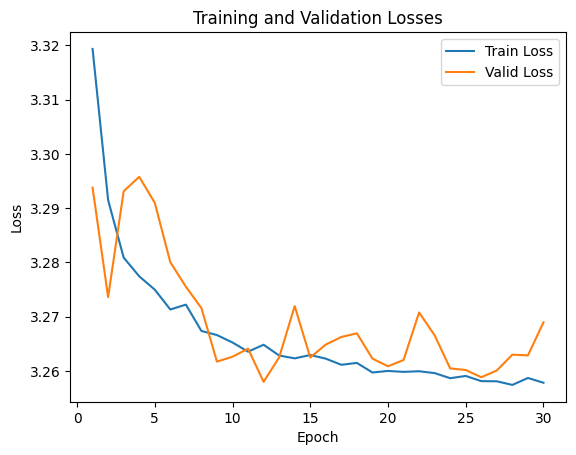

In [ ]:

plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [ ]:
model.eval()
total_correct = 0
total_samples = 0
all_predicted = []
all_labels = []

for batch_data, batch_labels in test_loader:
    batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
    with torch.no_grad():
        outputs = model(batch_data)
    _, predicted = torch.max(outputs, 1)

    total_samples += batch_labels.size(0)
    total_correct += (predicted == batch_labels).sum().item()

    all_predicted.extend(predicted.cpu().numpy())
    all_labels.extend(batch_labels.cpu().numpy())

accuracy = total_correct / total_samples


print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.0347


## ResNet18 Embeddings

In [ ]:
class GestureDataset(Dataset):
    def __init__(self, data_dir, csv_path):
        self.data_dir = data_dir
        self.label_id_map = {}
        data = pd.read_csv(csv_path)
        for i in range(len(data)):
            video_id = str(data['video_id'][i])
            label_id = data['label_id'][i]
            if label_id != 0:
                self.label_id_map[video_id] = label_id
        self.video_ids = sorted(self.label_id_map.keys())

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        video_dir = os.path.join(self.data_dir, video_id)
        output = os.path.join(video_dir, 'output.pt')
        resnet_result = torch.load(output)
        label = self.label_id_map[video_id]
        return resnet_result, label - 1

data_dir = 'ResNet18'
csv_path = "Validation.csv"
dataset = GestureDataset(data_dir, csv_path)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

bs = 16
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)


print(f"Size of train_dataset: {train_size}")
print(f"Size of val_dataset: {val_size}")
print(f"Size of test_dataset: {test_size}")


Size of train_dataset: 5067
Size of val_dataset: 633
Size of test_dataset: 634


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super(MultiHeadAttention, self).__init__()
        assert d_model % nhead == 0
        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead
        self.fc_query = nn.Linear(d_model, d_model)
        self.fc_key = nn.Linear(d_model, d_model)
        self.fc_value = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value):
        batch_size = query.size(0)

        query = self.fc_query(query).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)
        key = self.fc_key(key).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)
        value = self.fc_value(value).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)

        scores = torch.matmul(query, key.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = torch.softmax(scores, dim=-1)
        attended_values = torch.matmul(attn_weights, value)

        concat_attended_values = attended_values.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        out = self.fc_out(concat_attended_values)
        return out

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, nhead)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        src2 = self.self_attn(src, src, src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        temp3 = self.linear1(src)
        temp2 = torch.relu(temp3)
        temp1 = self.dropout(temp2)
        src2 = self.linear2(temp1)
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class TemporalEncoder(nn.Module):
    def __init__(self, input_size, num_layers=6, nhead=8):
        super(TemporalEncoder, self).__init__()
        self.transformer_encoders = nn.ModuleList([TransformerEncoderLayer(input_size, nhead) for _ in range(num_layers)])
        self.avg_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = x.permute(1, 0, 2)
        for layer in self.transformer_encoders:
            x = layer(x)
        output = self.avg_pool(x.permute(1, 2, 0)).squeeze(-1)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class GestureRecognizer(nn.Module):
    def __init__(self, input_size, num_classes, num_layers=6, nhead=8, d_model=512):
        super(GestureRecognizer, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        self.temporal_encoder = TemporalEncoder(input_size, num_layers, nhead)
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        position_features = self.positional_encoding(x)
        temporal_features = self.temporal_encoder(position_features)
        output = self.fc(temporal_features)
        return output

In [ ]:
input_size = 512
num_classes = 26
num_layers = 6
d_model = 512
nhead = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GestureRecognizer(input_size, num_classes, num_layers, nhead, d_model).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


print(f"Using device: {device}")


Using device: cuda


In [ ]:
summary(model, (37, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1              [-1, 37, 512]               0
PositionalEncoding-2              [-1, 37, 512]               0
            Linear-3               [-1, 2, 512]         262,656
            Linear-4               [-1, 2, 512]         262,656
            Linear-5               [-1, 2, 512]         262,656
            Linear-6               [-1, 2, 512]         262,656
MultiHeadAttention-7               [-1, 2, 512]               0
           Dropout-8               [-1, 2, 512]               0
         LayerNorm-9               [-1, 2, 512]           1,024
           Linear-10              [-1, 2, 2048]       1,050,624
          Dropout-11              [-1, 2, 2048]               0
           Linear-12               [-1, 2, 512]       1,049,088
          Dropout-13               [-1, 2, 512]               0
        LayerNorm-14               [-1,

In [ ]:
num_epochs = 30
train_losses = []
valid_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    k = 0
    for batch_data, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() / len(train_loader)

        print(f'[{k}/{len(train_loader)}], Train Loss = {train_loss:.4f}', end = '\r')

        k += 1

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            valid_loss += loss.item() / len(val_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')


Epoch [1/30], Train Loss: 1.1874, Valid Loss: 0.7135
Epoch [2/30], Train Loss: 0.7250, Valid Loss: 0.7331
Epoch [3/30], Train Loss: 0.7075, Valid Loss: 0.6935
Epoch [4/30], Train Loss: 0.7123, Valid Loss: 0.6993
Epoch [5/30], Train Loss: 0.7060, Valid Loss: 0.6966
Epoch [6/30], Train Loss: 0.7075, Valid Loss: 0.8056
Epoch [7/30], Train Loss: 0.7242, Valid Loss: 0.7232
Epoch [8/30], Train Loss: 0.7143, Valid Loss: 0.7192
Epoch [9/30], Train Loss: 0.7267, Valid Loss: 0.8195
Epoch [10/30], Train Loss: 0.7099, Valid Loss: 0.6930
Epoch [11/30], Train Loss: 0.7119, Valid Loss: 0.6983
Epoch [12/30], Train Loss: 0.7435, Valid Loss: 0.7401
Epoch [13/30], Train Loss: 0.7220, Valid Loss: 0.7284
Epoch [14/30], Train Loss: 0.7007, Valid Loss: 0.7050
Epoch [15/30], Train Loss: 0.6953, Valid Loss: 0.7097
Epoch [16/30], Train Loss: 0.7007, Valid Loss: 0.7121
Epoch [17/30], Train Loss: 0.7031, Valid Loss: 0.7162
Epoch [18/30], Train Loss: 0.7030, Valid Loss: 0.7113
Epoch [19/30], Train Loss: 0.6962, Va

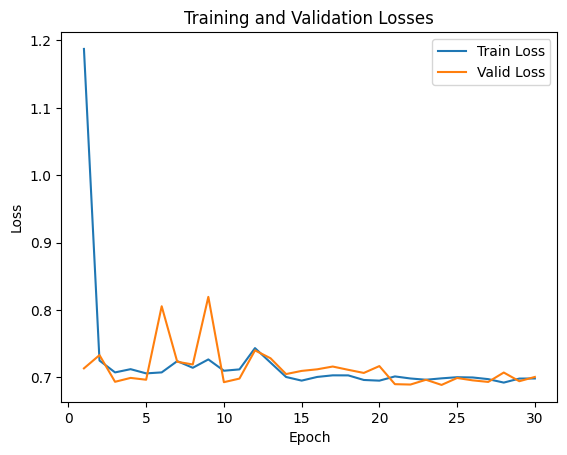

In [ ]:

plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [ ]:
model.eval()
total_correct = 0
total_samples = 0
all_predicted = []
all_labels = []

for batch_data, batch_labels in test_loader:
    batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
    with torch.no_grad():
        outputs = model(batch_data)
    _, predicted = torch.max(outputs, 1)

    total_samples += batch_labels.size(0)
    total_correct += (predicted == batch_labels).sum().item()

    all_predicted.extend(predicted.cpu().numpy())
    all_labels.extend(batch_labels.cpu().numpy())

accuracy = total_correct / total_samples


print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.4423


## ResNet50 Embeddings

In [ ]:
class GestureDataset(Dataset):
    def __init__(self, data_dir, csv_path):
        self.data_dir = data_dir
        self.label_id_map = {}
        data = pd.read_csv(csv_path)
        for i in range(len(data)):
            video_id = str(data['video_id'][i])
            label_id = data['label_id'][i]
            if label_id != 0:
                self.label_id_map[video_id] = label_id
        self.video_ids = sorted(self.label_id_map.keys())

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        video_dir = os.path.join(self.data_dir, video_id)
        output = os.path.join(video_dir, 'output.pt')
        resnet_result = torch.load(output)
        label = self.label_id_map[video_id]
        return resnet_result, label - 1

data_dir = 'ResNet50'
csv_path = "Validation.csv"
dataset = GestureDataset(data_dir, csv_path)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

bs = 16
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)


print(f"Size of train_dataset: {train_size}")
print(f"Size of val_dataset: {val_size}")
print(f"Size of test_dataset: {test_size}")


Size of train_dataset: 5067
Size of val_dataset: 633
Size of test_dataset: 634


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super(MultiHeadAttention, self).__init__()
        assert d_model % nhead == 0
        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead
        self.fc_query = nn.Linear(d_model, d_model)
        self.fc_key = nn.Linear(d_model, d_model)
        self.fc_value = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value):
        batch_size = query.size(0)

        query = self.fc_query(query).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)
        key = self.fc_key(key).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)
        value = self.fc_value(value).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)

        scores = torch.matmul(query, key.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = torch.softmax(scores, dim=-1)
        attended_values = torch.matmul(attn_weights, value)

        concat_attended_values = attended_values.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        out = self.fc_out(concat_attended_values)
        return out

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, nhead)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        src2 = self.self_attn(src, src, src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        temp3 = self.linear1(src)
        temp2 = torch.relu(temp3)
        temp1 = self.dropout(temp2)
        src2 = self.linear2(temp1)
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class TemporalEncoder(nn.Module):
    def __init__(self, input_size, num_layers=6, nhead=8):
        super(TemporalEncoder, self).__init__()
        self.transformer_encoders = nn.ModuleList([TransformerEncoderLayer(input_size, nhead) for _ in range(num_layers)])
        self.avg_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = x.permute(1, 0, 2)
        for layer in self.transformer_encoders:
            x = layer(x)
        output = self.avg_pool(x.permute(1, 2, 0)).squeeze(-1)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class GestureRecognizer(nn.Module):
    def __init__(self, input_size, num_classes, num_layers=6, nhead=8, d_model=512):
        super(GestureRecognizer, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        self.temporal_encoder = TemporalEncoder(input_size, num_layers, nhead)
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        position_features = self.positional_encoding(x)
        temporal_features = self.temporal_encoder(position_features)
        output = self.fc(temporal_features)
        return output

In [ ]:
input_size = 2048
num_classes = 26
num_layers = 6
d_model = 2048
nhead = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GestureRecognizer(input_size, num_classes, num_layers, nhead, d_model).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


print(f"Using device: {device}")


Using device: cuda


In [ ]:
summary(model, (37, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1             [-1, 37, 2048]               0
PositionalEncoding-2             [-1, 37, 2048]               0
            Linear-3              [-1, 2, 2048]       4,196,352
            Linear-4              [-1, 2, 2048]       4,196,352
            Linear-5              [-1, 2, 2048]       4,196,352
            Linear-6              [-1, 2, 2048]       4,196,352
MultiHeadAttention-7              [-1, 2, 2048]               0
           Dropout-8              [-1, 2, 2048]               0
         LayerNorm-9              [-1, 2, 2048]           4,096
           Linear-10              [-1, 2, 2048]       4,196,352
          Dropout-11              [-1, 2, 2048]               0
           Linear-12              [-1, 2, 2048]       4,196,352
          Dropout-13              [-1, 2, 2048]               0
        LayerNorm-14              [-1, 

In [ ]:
num_epochs = 30
train_losses = []
valid_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    k = 0
    for batch_data, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() / len(train_loader)

        print(f'[{k}/{len(train_loader)}], Train Loss = {train_loss:.4f}', end = '\r')

        k += 1

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            valid_loss += loss.item() / len(val_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')


Epoch [1/30], Train Loss: 2.6649, Valid Loss: 0.8188
Epoch [2/30], Train Loss: 0.8175, Valid Loss: 0.6987
Epoch [3/30], Train Loss: 0.7804, Valid Loss: 0.6867
Epoch [4/30], Train Loss: 0.7558, Valid Loss: 0.7423
Epoch [5/30], Train Loss: 0.7470, Valid Loss: 0.7173
Epoch [6/30], Train Loss: 0.7011, Valid Loss: 0.6949
Epoch [7/30], Train Loss: 0.7848, Valid Loss: 0.8292
Epoch [8/30], Train Loss: 0.7950, Valid Loss: 0.7297
Epoch [9/30], Train Loss: 0.7568, Valid Loss: 0.6910
Epoch [10/30], Train Loss: 0.7132, Valid Loss: 0.6946
Epoch [11/30], Train Loss: 0.7068, Valid Loss: 0.6755
Epoch [12/30], Train Loss: 0.7145, Valid Loss: 0.7047
Epoch [13/30], Train Loss: 0.7033, Valid Loss: 0.6878
Epoch [14/30], Train Loss: 0.7080, Valid Loss: 0.7385
Epoch [15/30], Train Loss: 0.7149, Valid Loss: 0.6992
Epoch [16/30], Train Loss: 0.7009, Valid Loss: 0.6916
Epoch [17/30], Train Loss: 0.7096, Valid Loss: 0.6945
Epoch [18/30], Train Loss: 0.7081, Valid Loss: 0.6918
Epoch [19/30], Train Loss: 0.7019, Va

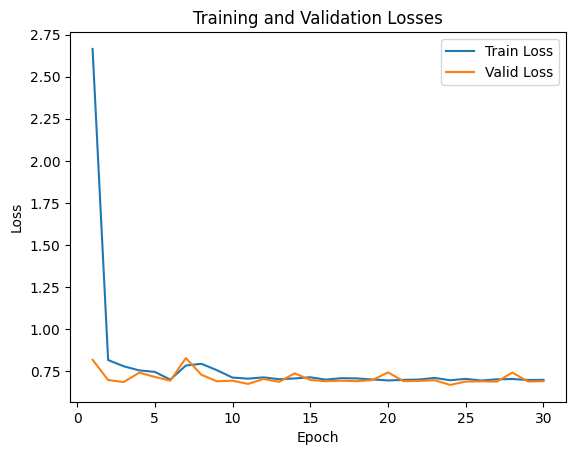

In [ ]:

plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()


In [ ]:
model.eval()
total_correct = 0
total_samples = 0
all_predicted = []
all_labels = []

for batch_data, batch_labels in test_loader:
    batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
    with torch.no_grad():
        outputs = model(batch_data)
    _, predicted = torch.max(outputs, 1)

    total_samples += batch_labels.size(0)
    total_correct += (predicted == batch_labels).sum().item()

    all_predicted.extend(predicted.cpu().numpy())
    all_labels.extend(batch_labels.cpu().numpy())

accuracy = total_correct / total_samples


print(f'Test Accuracy: {accuracy:.4f}')


Test Accuracy: 0.4808


## ResNet152_per50 Embeddings

In [ ]:
class GestureDataset(Dataset):
    def __init__(self, data_dir, csv_path):
        self.data_dir = data_dir
        self.label_id_map = {}
        data = pd.read_csv(csv_path)
        for i in range(len(data)):
            video_id = str(data['video_id'][i])
            label_id = data['label_id'][i]
            if label_id != 0:
                self.label_id_map[video_id] = label_id
        self.video_ids = sorted(self.label_id_map.keys())

    def __len__(self):
        return len(self.video_ids)

    def __getitem__(self, idx):
        video_id = self.video_ids[idx]
        video_dir = os.path.join(self.data_dir, video_id)
        output = os.path.join(video_dir, 'output.pt')
        resnet_result = torch.load(output)
        label = self.label_id_map[video_id]
        return resnet_result, label - 1

data_dir = 'ResNet152_per50'
csv_path = "Validation.csv"
dataset = GestureDataset(data_dir, csv_path)

train_size = int(0.8 * len(dataset))
val_size = int(0.1 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

bs = 16
train_loader = DataLoader(train_dataset, batch_size=bs, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=bs, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=bs, shuffle=True)


print(f"Size of train_dataset: {train_size}")
print(f"Size of val_dataset: {val_size}")
print(f"Size of test_dataset: {test_size}")


Size of train_dataset: 5067
Size of val_dataset: 633
Size of test_dataset: 634


In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, nhead):
        super(MultiHeadAttention, self).__init__()
        assert d_model % nhead == 0
        self.d_model = d_model
        self.nhead = nhead
        self.head_dim = d_model // nhead
        self.fc_query = nn.Linear(d_model, d_model)
        self.fc_key = nn.Linear(d_model, d_model)
        self.fc_value = nn.Linear(d_model, d_model)
        self.fc_out = nn.Linear(d_model, d_model)

    def forward(self, query, key, value):
        batch_size = query.size(0)

        query = self.fc_query(query).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)
        key = self.fc_key(key).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)
        value = self.fc_value(value).view(batch_size, -1, self.nhead, self.head_dim).transpose(1, 2)

        scores = torch.matmul(query, key.transpose(-2, -1)) / (self.head_dim ** 0.5)
        attn_weights = torch.softmax(scores, dim=-1)
        attended_values = torch.matmul(attn_weights, value)

        concat_attended_values = attended_values.transpose(1, 2).contiguous().view(batch_size, -1, self.d_model)
        out = self.fc_out(concat_attended_values)
        return out

class TransformerEncoderLayer(nn.Module):
    def __init__(self, d_model, nhead, dim_feedforward=2048, dropout=0.1):
        super(TransformerEncoderLayer, self).__init__()
        self.self_attn = MultiHeadAttention(d_model, nhead)
        self.linear1 = nn.Linear(d_model, dim_feedforward)
        self.dropout = nn.Dropout(dropout)
        self.linear2 = nn.Linear(dim_feedforward, d_model)
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)
        self.dropout1 = nn.Dropout(dropout)
        self.dropout2 = nn.Dropout(dropout)

    def forward(self, src):
        src2 = self.self_attn(src, src, src)
        src = src + self.dropout1(src2)
        src = self.norm1(src)
        temp3 = self.linear1(src)
        temp2 = torch.relu(temp3)
        temp1 = self.dropout(temp2)
        src2 = self.linear2(temp1)
        src = src + self.dropout2(src2)
        src = self.norm2(src)
        return src

class TemporalEncoder(nn.Module):
    def __init__(self, input_size, num_layers=6, nhead=8):
        super(TemporalEncoder, self).__init__()
        self.transformer_encoders = nn.ModuleList([TransformerEncoderLayer(input_size, nhead) for _ in range(num_layers)])
        self.avg_pool = nn.AdaptiveAvgPool1d(1)

    def forward(self, x):
        x = x.permute(1, 0, 2)
        for layer in self.transformer_encoders:
            x = layer(x)
        output = self.avg_pool(x.permute(1, 2, 0)).squeeze(-1)
        return output

class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=0.1)

        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

class GestureRecognizer(nn.Module):
    def __init__(self, input_size, num_classes, num_layers=6, nhead=8, d_model=512):
        super(GestureRecognizer, self).__init__()
        self.positional_encoding = PositionalEncoding(d_model)
        self.temporal_encoder = TemporalEncoder(input_size, num_layers, nhead)
        self.fc = nn.Linear(input_size, num_classes)

    def forward(self, x):
        position_features = self.positional_encoding(x)
        temporal_features = self.temporal_encoder(position_features)
        output = self.fc(temporal_features)
        return output

In [ ]:
input_size = 512
num_classes = 26
num_layers = 6
d_model = 512
nhead = 8

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GestureRecognizer(input_size, num_classes, num_layers, nhead, d_model).to(device)
criterion = nn.CrossEntropyLoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)


print(f"Using device: {device}")


Using device: cuda


/home/bcca/miniconda3/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


In [ ]:
summary(model, (37, input_size))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Dropout-1              [-1, 37, 512]               0
PositionalEncoding-2              [-1, 37, 512]               0
            Linear-3               [-1, 2, 512]         262,656
            Linear-4               [-1, 2, 512]         262,656
            Linear-5               [-1, 2, 512]         262,656
            Linear-6               [-1, 2, 512]         262,656
MultiHeadAttention-7               [-1, 2, 512]               0
           Dropout-8               [-1, 2, 512]               0
         LayerNorm-9               [-1, 2, 512]           1,024
           Linear-10              [-1, 2, 2048]       1,050,624
          Dropout-11              [-1, 2, 2048]               0
           Linear-12               [-1, 2, 512]       1,049,088
          Dropout-13               [-1, 2, 512]               0
        LayerNorm-14               [-1,

In [ ]:
num_epochs = 30
train_losses = []
valid_losses = []
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    k = 0
    for batch_data, batch_labels in train_loader:
        batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
        optimizer.zero_grad()
        outputs = model(batch_data)
        loss = criterion(outputs, batch_labels)

        loss.backward()
        optimizer.step()

        train_loss += loss.item() / len(train_loader)

        print(f'[{k}/{len(train_loader)}], Train Loss = {train_loss:.4f}', end = '\r')

        k += 1

    model.eval()
    valid_loss = 0.0
    with torch.no_grad():
        for batch_data, batch_labels in val_loader:
            batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
            outputs = model(batch_data)
            loss = criterion(outputs, batch_labels)
            valid_loss += loss.item() / len(val_loader)

    train_losses.append(train_loss)
    valid_losses.append(valid_loss)


    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Valid Loss: {valid_loss:.4f}')


Epoch [1/30], Train Loss: 1.2322, Valid Loss: 0.7013
Epoch [2/30], Train Loss: 0.7218, Valid Loss: 0.6947
Epoch [3/30], Train Loss: 0.7044, Valid Loss: 0.6860
Epoch [4/30], Train Loss: 0.7137, Valid Loss: 0.6849
Epoch [5/30], Train Loss: 0.7199, Valid Loss: 0.7147
Epoch [6/30], Train Loss: 0.7182, Valid Loss: 0.6957
Epoch [7/30], Train Loss: 0.7180, Valid Loss: 0.6898
Epoch [8/30], Train Loss: 0.7064, Valid Loss: 0.6651
Epoch [9/30], Train Loss: 0.7211, Valid Loss: 0.6861
Epoch [10/30], Train Loss: 0.7171, Valid Loss: 0.6972
Epoch [11/30], Train Loss: 0.7027, Valid Loss: 0.6825
Epoch [12/30], Train Loss: 0.7010, Valid Loss: 0.7016
Epoch [13/30], Train Loss: 0.7069, Valid Loss: 0.6991
Epoch [14/30], Train Loss: 0.7113, Valid Loss: 0.6954
Epoch [15/30], Train Loss: 0.7061, Valid Loss: 0.6931
Epoch [16/30], Train Loss: 0.6991, Valid Loss: 0.6967
Epoch [17/30], Train Loss: 0.7119, Valid Loss: 0.7104
Epoch [18/30], Train Loss: 0.6983, Valid Loss: 0.7276
Epoch [19/30], Train Loss: 0.6965, Va

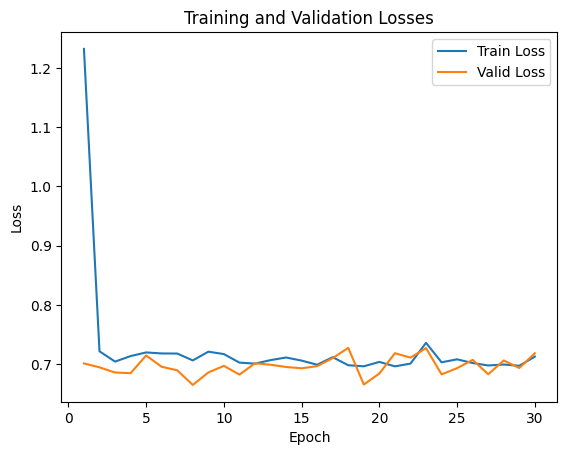

In [ ]:
plt.plot(range(1, num_epochs+1), train_losses, label='Train Loss')
plt.plot(range(1, num_epochs+1), valid_losses, label='Valid Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

In [ ]:
model.eval()
total_correct = 0
total_samples = 0
all_predicted = []
all_labels = []

for batch_data, batch_labels in test_loader:
    batch_data, batch_labels = batch_data.to(device), batch_labels.to(device)
    with torch.no_grad():
        outputs = model(batch_data)
    _, predicted = torch.max(outputs, 1)

    total_samples += batch_labels.size(0)
    total_correct += (predicted == batch_labels).sum().item()

    all_predicted.extend(predicted.cpu().numpy())
    all_labels.extend(batch_labels.cpu().numpy())

accuracy = total_correct / total_samples

print(f'Test Accuracy: {accuracy:.4f}')

Test Accuracy: 0.5577


# 3D CNN

In [ ]:
from keras.layers import Conv3D, MaxPool3D, Flatten, Dense
from keras.layers import Dropout, Input, BatchNormalization
from sklearn.metrics import confusion_matrix, accuracy_score
from keras.losses import categorical_crossentropy
from keras.optimizers import Adadelta

from matplotlib.pyplot import cm
from keras.models import Model
import numpy as np
import keras
from tensorflow.keras.layers import Input, Conv3D, MaxPool3D, BatchNormalization, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers

In [ ]:
labels = pd.read_csv('Validation.csv')
labels.set_index('video_id', inplace=True)
print(labels.loc[int('22')])

def load_video_frames(directory, num_videos=100):
    video_frames = []
    video_folders = sorted(os.listdir(directory))[:num_videos]

    for folder_name in video_folders:
        folder_path = os.path.join(directory, folder_name)
        frames = []
        for file in sorted(os.listdir(folder_path)):
            if file.endswith('.jpg') or file.endswith('.png'):
                frame_path = os.path.join(folder_path, file)
                frame = Image.open(frame_path)
                frame = frame.resize((100, 100))
                frames.append(np.array(frame))

        label = labels.loc[int(folder_name)]['label_id']
        datapoint = [frames, label]
        if frames:
            video_frames.append(datapoint)
    return video_frames

video_directory = "Validation"
videos_dataset = load_video_frames(video_directory, num_videos=100)

def load_video_frames(directory, num_videos=100, max_frames=50):
    video_frames = []
    video_labels = []
    video_folders = sorted(os.listdir(directory))[:num_videos]

    for folder_name in video_folders:
        folder_path = os.path.join(directory, folder_name)
        frames = []
        for file in sorted(os.listdir(folder_path)):
            if file.endswith('.jpg') or file.endswith('.png'):
                frame_path = os.path.join(folder_path, file)
                frame = Image.open(frame_path)
                frame = frame.resize((100, 100))
                frames.append(np.array(frame))

        label = labels.loc[int(folder_name)]['label_id']
        if frames:
            video_frames.append(frames)
            video_labels.append(label)

    video_frames = np.array(video_frames)
    video_labels = np.array(video_labels)
    return video_frames, video_labels

video_directory = "Validation"
X,y = load_video_frames(video_directory, num_videos=100)

print(X.shape)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set - X:", X_train.shape, " y:", y_train.shape)
print("Test set - X:", X_test.shape, " y:", y_test.shape)


y_train = keras.utils.to_categorical(y_train, 27)
y_test = keras.utils.to_categorical(y_test, 27)


# input layer
input_layer = Input((37, 100, 100, 3))

# convolutional layers
conv_layer1 = Conv3D(filters=2, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(input_layer)
conv_layer1 = Dropout(0.4)(conv_layer1)
conv_layer2 = Conv3D(filters=4, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(conv_layer1)
pooling_layer1 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer2)

conv_layer3 = Conv3D(filters=4, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(pooling_layer1)
conv_layer4 = Conv3D(filters=6, kernel_size=(3, 3, 3), activation='relu', kernel_regularizer=regularizers.l2(0.01))(conv_layer3)
pooling_layer2 = MaxPool3D(pool_size=(2, 2, 2))(conv_layer4)

pooling_layer2 = BatchNormalization()(pooling_layer2)
flatten_layer = Flatten()(pooling_layer2)

dense_layer1 = Dense(units=2048, activation='relu', kernel_regularizer=regularizers.l2(0.01))(flatten_layer)
dense_layer1 = Dropout(0.4)(dense_layer1)
dense_layer2 = Dense(units=512, activation='relu', kernel_regularizer=regularizers.l2(0.01))(dense_layer1)
dense_layer2 = Dropout(0.4)(dense_layer2)
output_layer = Dense(units=27, activation='softmax')(dense_layer2)
model = Model(inputs=input_layer, outputs=output_layer)

model.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0001), metrics=['acc'])

# Training loop
history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    epochs=50,
    callbacks=[
        ModelCheckpoint('./models/3DCNN.keras', monitor='val_acc', verbose=1, save_best_only=True, mode='auto'),
        ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=50, verbose=1, mode='auto'),
        EarlyStopping(monitor='val_acc', patience=100, verbose=1, mode='auto', restore_best_weights=True)
    ]
)

label       Zooming In With Full Hand
frames                             37
label_id                           23
shape                      (100, 176)
format                           JPEG
Name: 22, dtype: object
(100, 37, 100, 100, 3)
Train set - X: (80, 37, 100, 100, 3)  y: (80,)
Test set - X: (20, 37, 100, 100, 3)  y: (20,)
Epoch 1/50
2/2 [==============================] - ETA: 0s - loss: 50.0952 - acc: 0.0312 
Epoch 1: val_acc improved from -inf to 0.00000, saving model to ./models/3DCNN.keras
2/2 [==============================] - 22s 8s/step - loss: 50.0952 - acc: 0.0312 - val_loss: 51.8125 - val_acc: 0.0000e+00 - lr: 1.0000e-04
Epoch 2/50
2/2 [==============================] - ETA: 0s - loss: 48.7917 - acc: 0.1094
Epoch 2: val_acc did not improve from 0.00000
2/2 [==============================] - 1s 433ms/step - loss: 48.7917 - acc: 0.1094 - val_loss: 51.1953 - val_acc: 0.0000e+00 - lr: 1.0000e-04
Epoch 3/50
2/2 [==============================] - ETA: 0s - loss: 47.9440 - acc: